In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# 데이터 불러오기 및 전처리
data_row=pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0426/train/sentence 5/train_data_after_vector.csv",index_col=0)
y_train = pd.get_dummies(data_row['predict']).values
X_train = data_row.drop(columns=['predict']).values

test = pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0426/test/sentence 5/test_data_after_vector.csv", index_col=0)
test_y = pd.get_dummies(test['predict']).values
test_x = test.drop(columns=['predict']).values

In [3]:
# PyTorch Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float)
test_x = torch.tensor(test_x, dtype=torch.float).unsqueeze(1)
test_y = torch.tensor(test_y, dtype=torch.float)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([9324, 1, 768])
torch.Size([9324, 3])
torch.Size([300, 1, 768])
torch.Size([300, 3])


In [5]:
# DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset,shuffle=False)

In [6]:
class Fishing_Detection(nn.Module):
    def __init__(self):
        super(Fishing_Detection, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(128)  # 배치 정규화 추가
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(64)  # 배치 정규화 추가
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(32)  # 배치 정규화 추가
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(input_size=32, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(128*2, 32)
        self.fc2 = nn.Linear(32, 3)
        self.activation = nn.ELU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = Fishing_Detection()

In [7]:
# 손실 함수 및 최적화 알고리즘 설정
from adamp import AdamP
#from keras_radam import RAdam
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=1e-5)

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

 
# 스케쥴러 정의
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.25, verbose=True)

num_epochs = 200
training_losses = []
validation_losses = []

patience = 30
counter = 0
best_loss = None

# 체크포인트 저장 경로 설정
checkpoint_path = 'model_checkpoint.pt'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            validation_loss += loss.item()
    
    avg_validation_loss = validation_loss / len(test_loader)
    validation_losses.append(avg_validation_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_validation_loss}')
    
    # 스케쥴러 단계
    scheduler.step(avg_validation_loss)
    
    # 모델 체크포인트 저장
    if best_loss is None:
        best_loss = avg_validation_loss
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, checkpoint_path)
    elif avg_validation_loss < best_loss:
        best_loss = avg_validation_loss
        counter = 0
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, checkpoint_path)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

print('Model Train End')


/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 0.49951072544493574, Validation Loss: 0.3176243177075715
Epoch 2, Training Loss: 0.29855194941480107, Validation Loss: 0.348083825827786
Epoch 3, Training Loss: 0.26503105937166416, Validation Loss: 0.21712576927855784
Epoch 4, Training Loss: 0.2183896242938143, Validation Loss: 0.17421908790869567
Epoch 5, Training Loss: 0.1693803090998467, Validation Loss: 0.227102031134829
Epoch 6, Training Loss: 0.14956299500896575, Validation Loss: 0.125072597727977
Epoch 7, Training Loss: 0.12684502088009042, Validation Loss: 0.14407788720209888
Epoch 8, Training Loss: 0.11424409613964405, Validation Loss: 0.0895194165586319
Epoch 9, Training Loss: 0.10362712832841467, Validation Loss: 0.3455482272279744
Epoch 10, Training Loss: 0.09524931029436436, Validation Loss: 0.1643505210556193
Epoch 11, Training Loss: 0.08665287455028677, Validation Loss: 0.05969631330716491
Epoch 12, Training Loss: 0.08394886347207617, Validation Loss: 0.07269269589527634
Epoch 13, Training Loss: 

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

In [11]:
torch.save(model.state_dict(), 'pytorch cnn-bilstm model_state_dict 0427.pt')

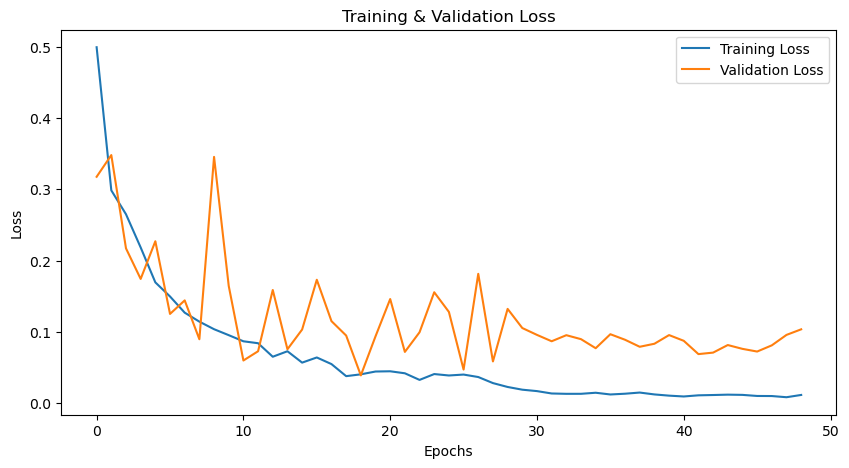

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

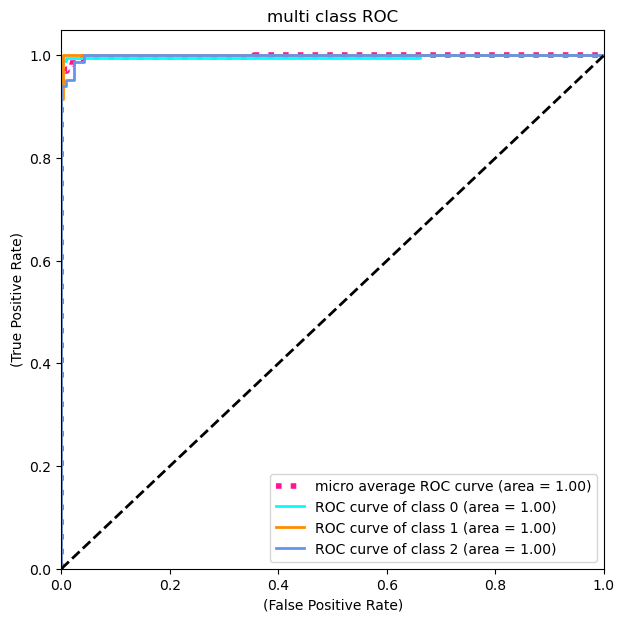

In [13]:
# ROC Curve 그리기 함수
def plot_multiclass_roc_curve(test_y, y_score, n_classes):
    # test_y를 이진화 (One-hot encoding)
    test_y_bin = label_binarize(test_y, classes=[*range(n_classes)])

    # 각 클래스에 대한 FPR, TPR, ROC AUC 계산
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 마이크로 평균 ROC 곡선 및 ROC 면적 계산
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # ROC 곡선 그리기
    plt.figure(figsize=(7, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('(False Positive Rate)')
    plt.ylabel('(True Positive Rate)')
    plt.title('multi class ROC')
    plt.legend(loc="lower right")
    plt.show()

# 사용 예시
from sklearn.preprocessing import label_binarize

# test_y 예시: 실제 타겟 레이블
# y_score 예시: 모델이 예측한 확률
# n_classes: 클래스의 개수, 이 경우에는 3
y_score = model(test_x).detach().numpy()
plot_multiclass_roc_curve(test_y, y_score, n_classes=3)

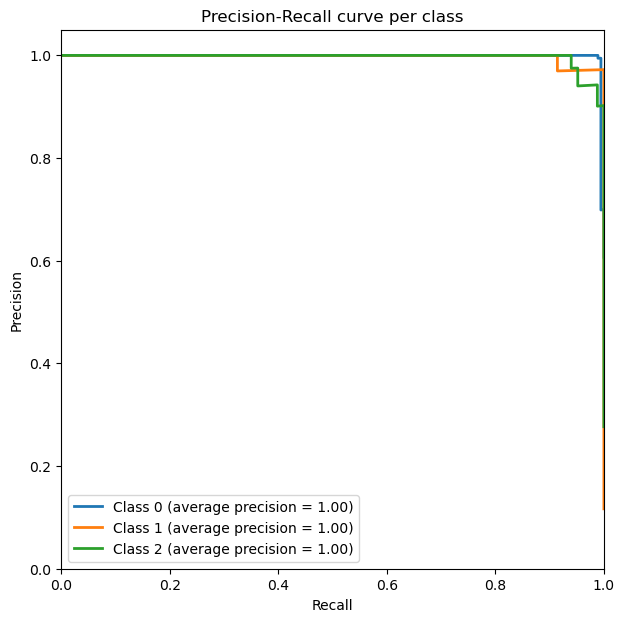

In [14]:
def plot_precision_recall_curve(test_y, y_score, n_classes):
    # test_y를 이진화
    test_y = label_binarize(test_y, classes=[*range(n_classes)])
    
    # 클래스별 Precision-Recall Curve와 평균 Precision을 계산하고 그립니다.
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(test_y[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(test_y[:, i], y_score[:, i])

    # 각 클래스에 대한 Precision-Recall Curve를 그립니다.
    plt.figure(figsize=(7, 7))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (average precision = {average_precision[i]:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve per class')
    plt.legend(loc="best")
    plt.show()
    
plot_precision_recall_curve(test_y, y_score, n_classes=3)

In [15]:
# 예측값 생성
y_pred = np.argmax(y_score, axis=1)
test_y_labels = np.argmax(test_y, axis=1)  # 실제 레이블

In [16]:
# 정확도
accuracy = accuracy_score(test_y_labels, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9766666666666667


In [17]:
# 혼동 행렬
conf_matrix = confusion_matrix(test_y_labels, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[179   1   2]
 [  0  35   0]
 [  0   4  79]]


In [18]:
with open("CNN LSTM confusion matrix.txt", "w") as text_file:
    print(confusion_matrix(test_y_labels, y_pred), file=text_file)

In [19]:
# 분류 보고서
class_report = classification_report(test_y_labels, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       182
           1       0.88      1.00      0.93        35
           2       0.98      0.95      0.96        83

    accuracy                           0.98       300
   macro avg       0.95      0.98      0.96       300
weighted avg       0.98      0.98      0.98       300



In [20]:
with open("CNN-LSTM output.txt", "w") as text_file:
    print(classification_report(test_y_labels, y_pred,digits=4), file=text_file)